### IMPORTING LIBRARIES

In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

### IMPORTING THE DATASET

In [2]:
file = "C:/Users/TEMP.LAPTOP-C50DVQCH.001/Desktop/daily_forex_rates.csv"
DF = pd.read_csv(file)
DF.head()


,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,342.057845,2024-04-16
1,GHS,EUR,Ghanaian Cedi,14.259829,2024-04-16
2,HRK,EUR,Croatian Kuna,7.521203,2024-04-16
3,HNL,EUR,Honduran Lempira,26.213711,2024-04-16
4,HKD,EUR,Hong Kong Dollar,8.319712,2024-04-16


### Dataset Description



### Objective

### Defining x and y variable

### EDA

In [3]:
print("There are {} rows and {} columns in the dataset.".format(DF.shape[0], DF.shape[1]))

There are 350583 rows and 5 columns in the dataset.


In [4]:
#Converting the 'date' column to datetime format ensures standardized date handling for efficient time-based operations.
DF['date'] = pd.to_datetime(DF['date'])

In [5]:
# FOR JAPAN
currency = ['JPY']
df_JPY = DF[DF['currency'].isin(currency)]

# Display the filtered DataFrame
print(df_JPY)

       currency base_currency currency_name  exchange_rate       date
32          JPY           EUR  Japanese Yen     164.213483 2024-04-16
249         JPY           EUR  Japanese Yen     164.082383 2024-04-15
378         JPY           EUR  Japanese Yen     163.554332 2024-04-14
595         JPY           EUR  Japanese Yen     163.554363 2024-04-13
724         JPY           EUR  Japanese Yen     163.014423 2024-04-12
...         ...           ...           ...            ...        ...
350563      JPY           EUR  Japanese Yen     132.830000 2004-09-06
350570      JPY           EUR  Japanese Yen     133.360000 2004-09-03
350573      JPY           EUR  Japanese Yen     133.220000 2004-09-02
350578      JPY           EUR  Japanese Yen     133.350000 2004-09-01
350580      JPY           EUR  Japanese Yen     132.850000 2004-08-31

[5168 rows x 5 columns]


In [6]:
df_JPY['date'].min(), df_JPY['date'].max()

(Timestamp('2004-08-31 00:00:00'), Timestamp('2024-04-16 00:00:00'))

In [7]:
# Filter the DataFrame to include values from 2018 to 2024
df_JPY = df_JPY[(df_JPY['date'] >= '2018-01-01') & (df_JPY['date'] <= '2024-12-31')]

In [8]:
df_JPY = df_JPY[['date','exchange_rate']]
df_JPY = df_JPY.sort_values('date')
df_JPY

,date,exchange_rate
222452,2018-01-01,135.279000
222257,2018-01-02,135.323000
222116,2018-01-03,135.180000
222101,2018-01-04,136.138000
221878,2018-01-05,135.970000
...,...,...
724,2024-04-12,163.014423
595,2024-04-13,163.554363
378,2024-04-14,163.554332
249,2024-04-15,164.082383


In [9]:
# To check presence of total no. of missing values
df_JPY.isnull().sum()

date             0
exchange_rate    0
dtype: int64

**Interpretation:**

There are no misssing values in our dataset.

In [10]:
df_JPY.head()

,date,exchange_rate
222452,2018-01-01,135.279
222257,2018-01-02,135.323
222116,2018-01-03,135.180
222101,2018-01-04,136.138
221878,2018-01-05,135.970


In [11]:
#Let's make a copy of our dataset in case we might need it for future purposes.
data = df_JPY.copy()

In [12]:
## Display a concise summary of the DataFrame, including the data types of each column, the number of non-null values, and memory usage.
df_JPY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 222452 to 32
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1690 non-null   datetime64[ns]
 1   exchange_rate  1690 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.6 KB


In [13]:
df_JPY= df_JPY.groupby('date')['exchange_rate'].mean().reset_index()

In [14]:
## Set 'date' as index
df_JPY = df_JPY.set_index('date')
df_JPY.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-08', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12',
               ...
               '2024-04-07', '2024-04-08', '2024-04-09', '2024-04-10',
               '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14',
               '2024-04-15', '2024-04-16'],
              dtype='datetime64[ns]', name='date', length=1690, freq=None)

In [15]:
df_JPY.index = pd.to_datetime(df_JPY.index)

In [16]:
#Create weekly samples of the data
y = df_JPY['exchange_rate'].resample('W').mean()

In [17]:
y

date
2018-01-07    135.578000
2018-01-14    134.456000
2018-01-21    135.514400
2018-01-28    135.516600
2018-02-04    135.884400
                 ...    
2024-03-24    164.027255
2024-03-31    163.678612
2024-04-07    164.034529
2024-04-14    164.006462
2024-04-21    164.147933
Freq: W-SUN, Name: exchange_rate, Length: 329, dtype: float64

In [18]:
#print the dataset from 2023-2024
y['2023':'2024']

date
2023-01-01    141.626400
2023-01-08    139.823800
2023-01-15    140.932800
2023-01-22    139.221000
2023-01-29    141.614400
                 ...    
2024-03-24    164.027255
2024-03-31    163.678612
2024-04-07    164.034529
2024-04-14    164.006462
2024-04-21    164.147933
Freq: W-SUN, Name: exchange_rate, Length: 69, dtype: float64

<Axes: xlabel='exchange_rate', ylabel='Density'>

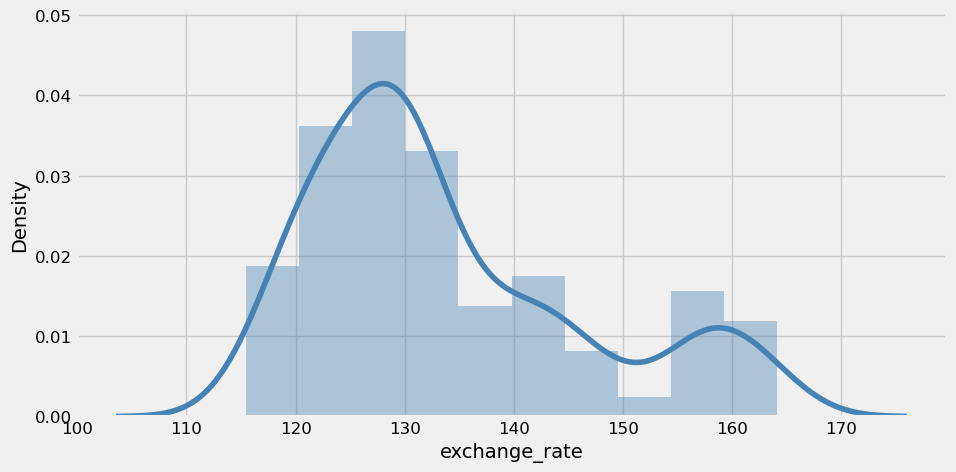

In [19]:
#check the distribution of the plot
plt.figure(figsize=(10,5))
sns.distplot(y, bins=10, color='steelblue')

**Interpretation:**

Looking at the histogram, the data seems to be positively skewed. The distribution has a longer right tail, with the majority of the data clustered towards the left.

Text(0.5, 0, 'Plot')

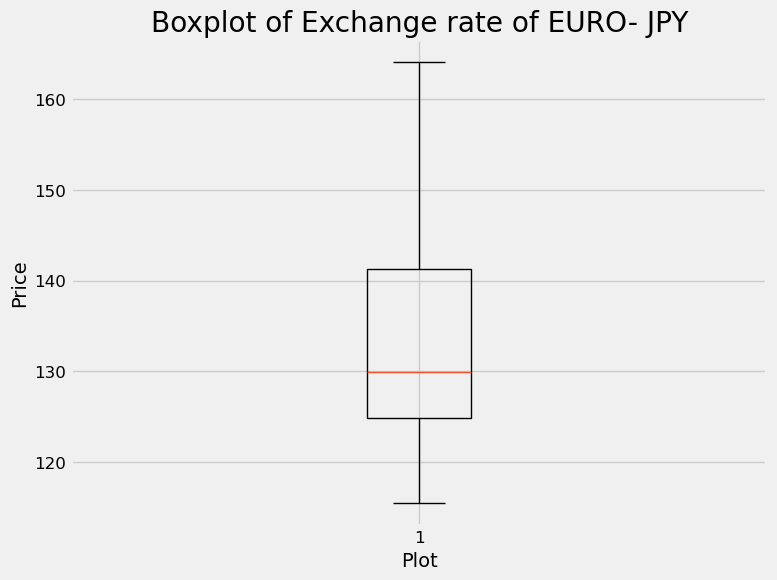

In [20]:
# To check presence of Outliers in the dataset
plt.figure(figsize=(8, 6))
box = plt.boxplot(y)
plt.title('Boxplot of Exchange rate of EURO- JPY')
plt.ylabel('Price')
plt.xlabel('Plot')

Interpretation:

There are no outliers in our dataset. The plot signifies positive skewness. The data has a larger number of values clustered towards the lower end and a few extreme values on the higher end.

In [21]:
# Display summary statistics of the numerical columns in the DataFrame, such as count, mean, standard deviation, minimum, maximum, and quartiles.
print("Summary Statistics:")
y.describe()

Summary Statistics:


count    329.000000
mean     133.762410
std       12.630562
min      115.437400
25%      124.831600
50%      129.935200
75%      141.290800
max      164.147933
Name: exchange_rate, dtype: float64

### SARIMAX MODELLING

In [22]:
#To check whether the data is stationary or not
X = (df_JPY['exchange_rate'].dropna()).values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: 0.133301
p-value: 0.968263
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


**Interpretation:**

The Augmented Dickey-Fuller (ADF) test is commonly used to assess the stationarity of a time series. The null hypothesis (H0) and alternative hypothesis (H1) for the ADF test can be stated as follows:

Null Hypothesis (H0): The time series data has a unit root, indicating that it is non-stationary.

Alternative Hypothesis (H1): The time series data does not have a unit root, indicating that it is stationary.

Criteria: If the test statistic exceeds critical values or if the p-value is smaller than 0.05 , the null hypothesis of a unit root is rejected, indicating stationarity.

In this case:

The ADF statistic (0.123278) is greater than critical values at all significance levels.
Since, the P-value(0.967615) >0.05, we failt to reject the null hypothesis.This means our time series is non-stationary indicating it may exhibit trends or seasonality.

In [23]:
#To convert the closing price column into stationary
#Compute first-order difference of 'Close' column
df_JPY['diff'] = df_JPY['exchange_rate'].diff()

# Drop missing values resulting from differencing
df_JPY.dropna(inplace=True)

# Check for stationarity again
X = (df_JPY['diff'].dropna()).values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")


ADF Statistic: -22.262811
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject Ho - Time Series is Stationary


**Interpretation:**

The provided code calculates the first-order difference of the 'Exchange rate' column, effectively removing trends or seasonality present in the data.

Since the p-value (approximately  0.000000) > 0.05  and the test statistic being lower than all critical values, indicating strong evidence against the presence of a unit root and confirming stationarity.

Further when we do modeling, In the parameter of the model, we take the d value to be 1 because we have used differencing once to convert our column into stationary.

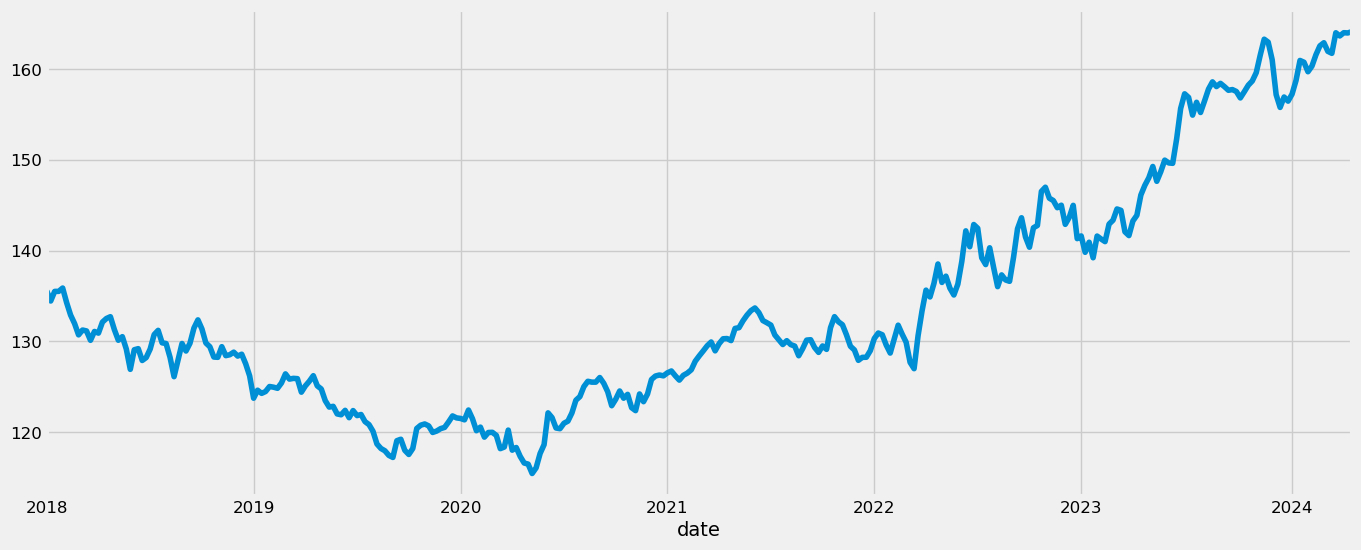

In [24]:
#Line plot of data from 2018-2024
y.plot(figsize=(15, 6))
plt.show()

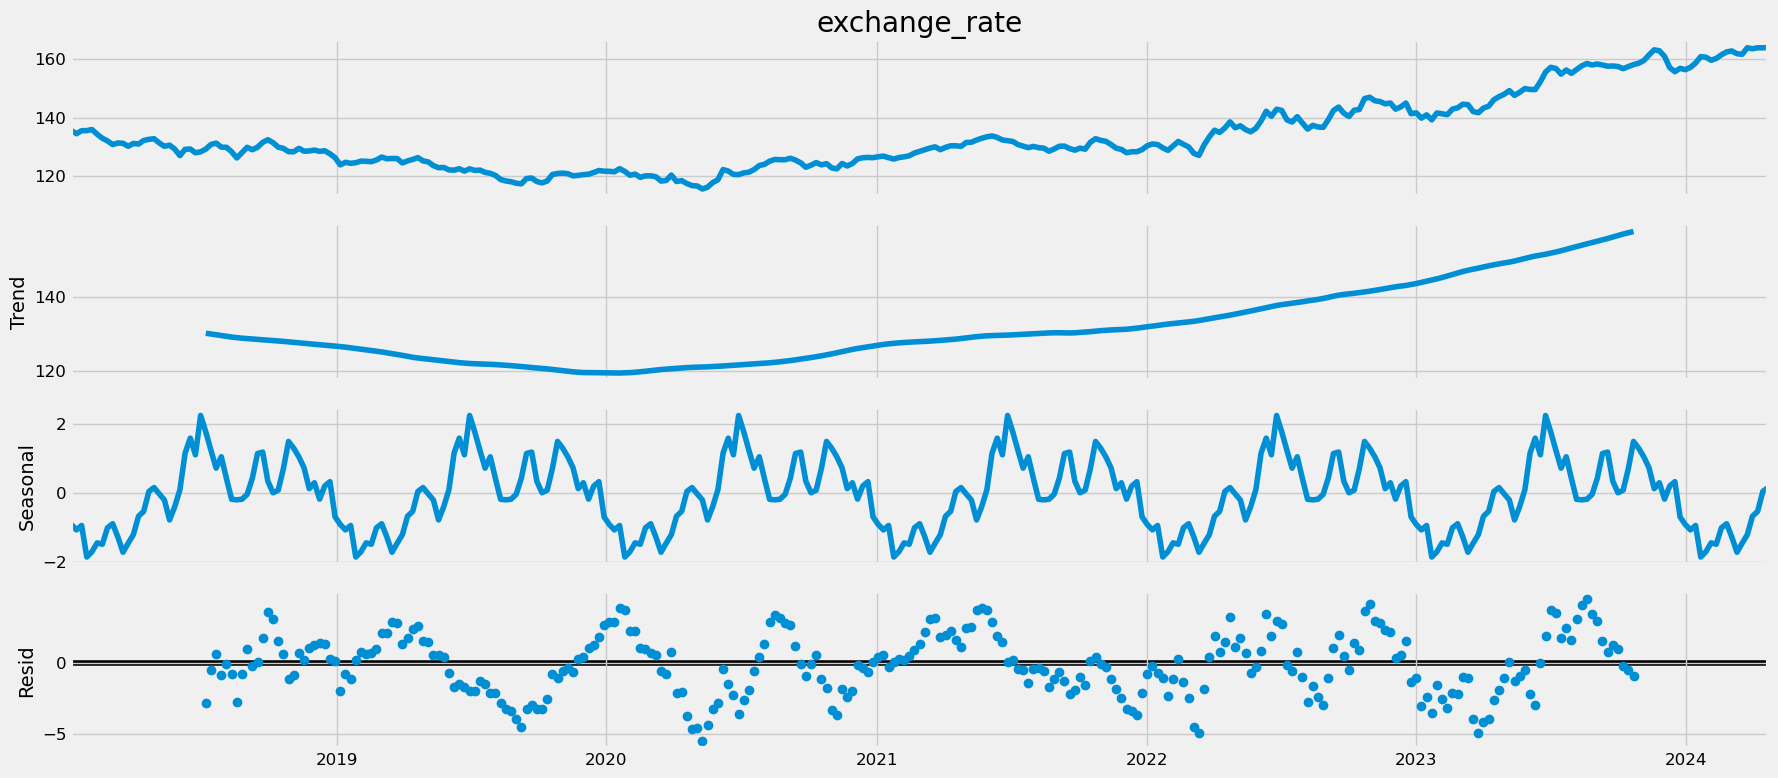

In [25]:
#Decomposition plot
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

**Interpretation:**

In the first plot, the line represents the actual closing prices of the stock over time. It captures the overall trend and fluctuations in the data.

Trend: The trend line appears to be approxiamtely flat, which suggests that there is no significant long-term increase or decrease in the exchange rate over this time period.

Seasonality: The seasonal component fluctuates around zero, but there is no clear seasonal pattern. This suggests that there are no consistent seasonal effects on the exchange rate.

Residuals: The residuals appear to be random with no significant patterns. This suggests that the trend and seasonality components capture most of the predictable patterns in the data, and the remaining variations are random noise.

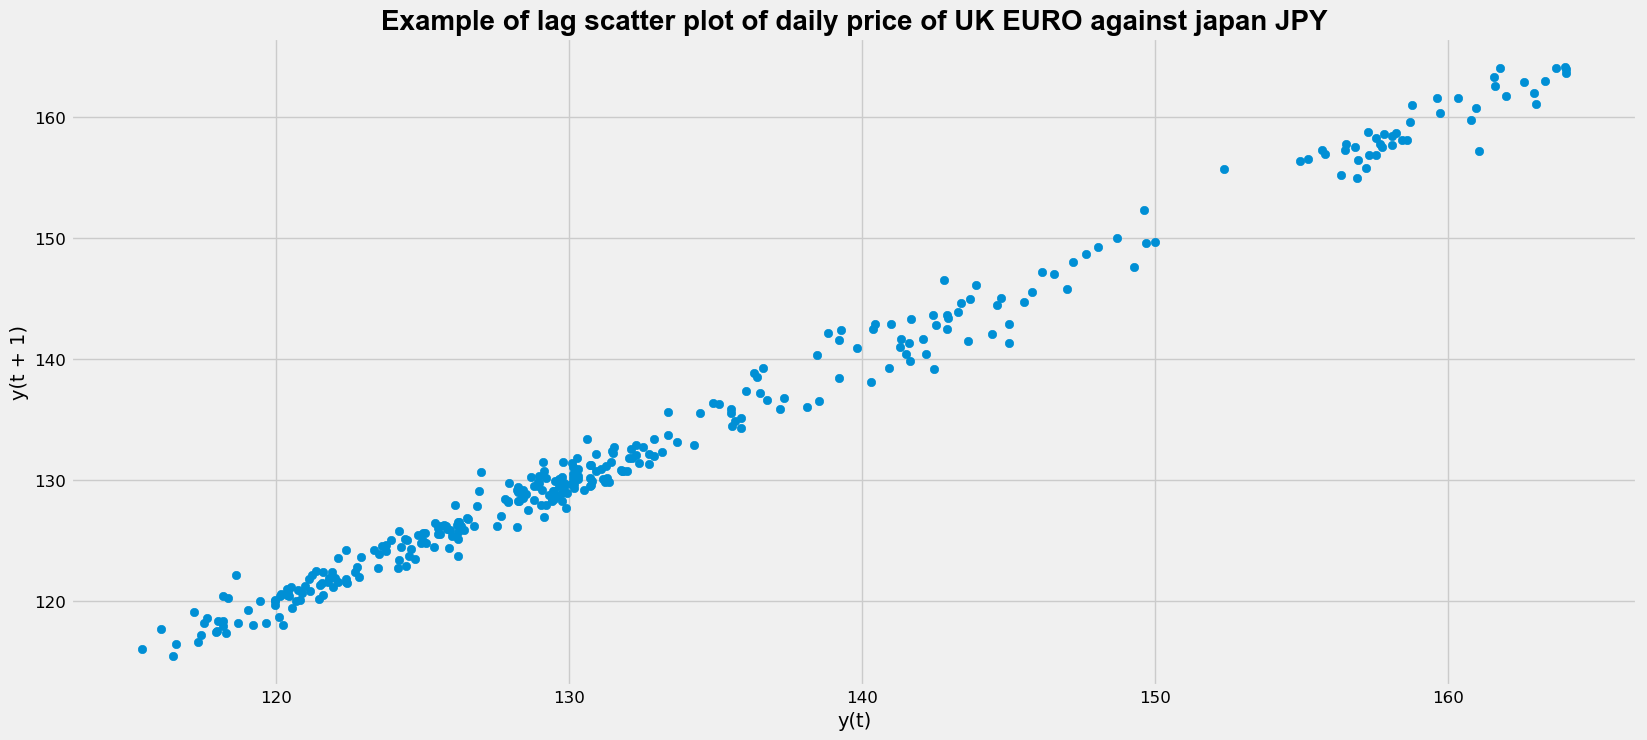

In [26]:
lag_plot(series = y)
plt.title('Example of lag scatter plot of daily price of UK EURO against japan JPY', weight='bold', family='Arial', fontsize=20)
plt.show()

**Interpretation:**

From the above lag plot, we can see that the values of exchange rates at time period T and T-1 are highly positively correlated

Positive Relationship: There appears to be a positive relationship between the price of the UK euro on one day and the price on the following day. This means that when the price of the euro is high on a given day, it tends to be high on the following day as well. Conversely, when the price is low on a given day, it tends to be low on the following day as well.

Scatter: The data points are scattered around a positive trend line, which indicates that the relationship is not perfect. There is some variability in the price of the euro from day to day.

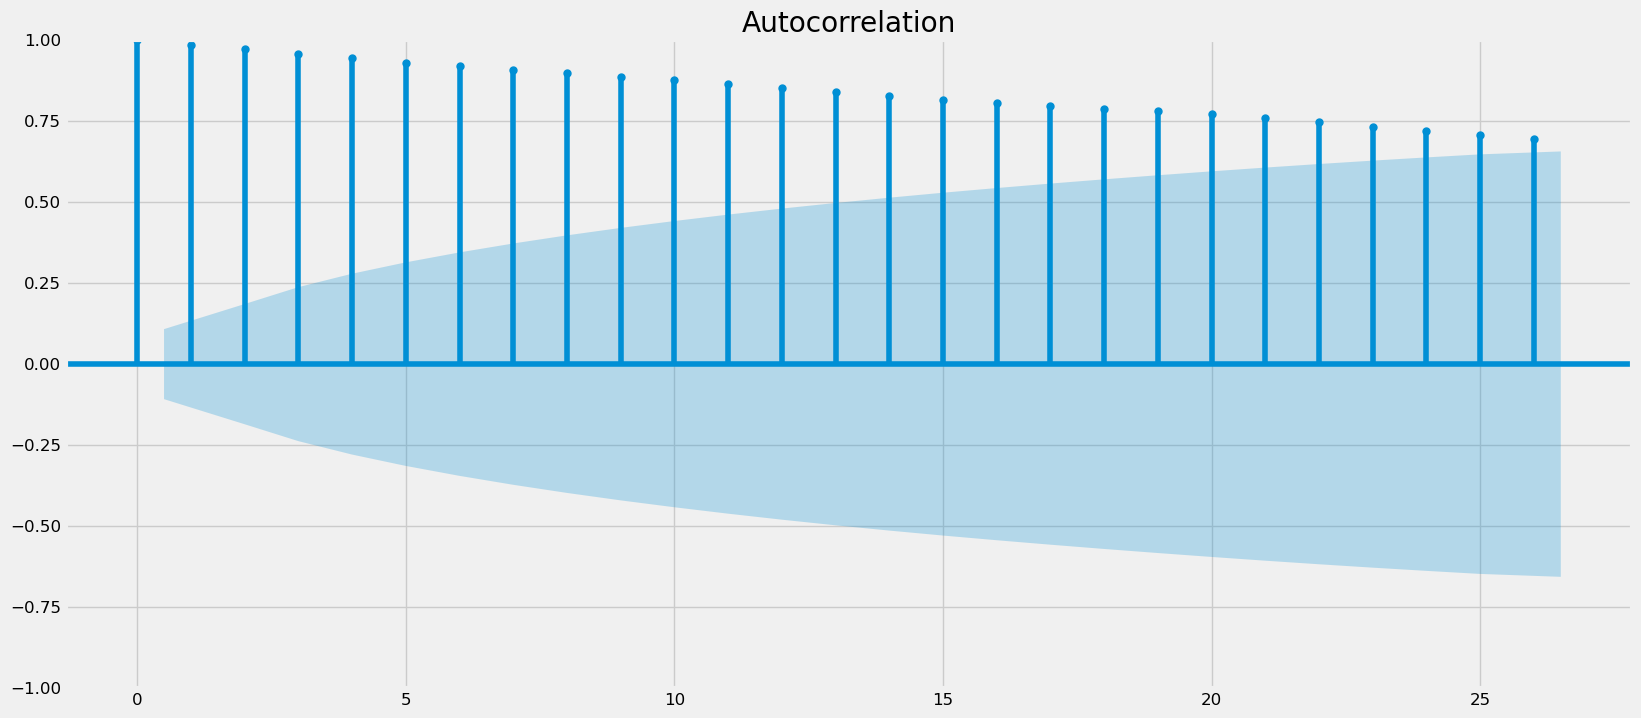

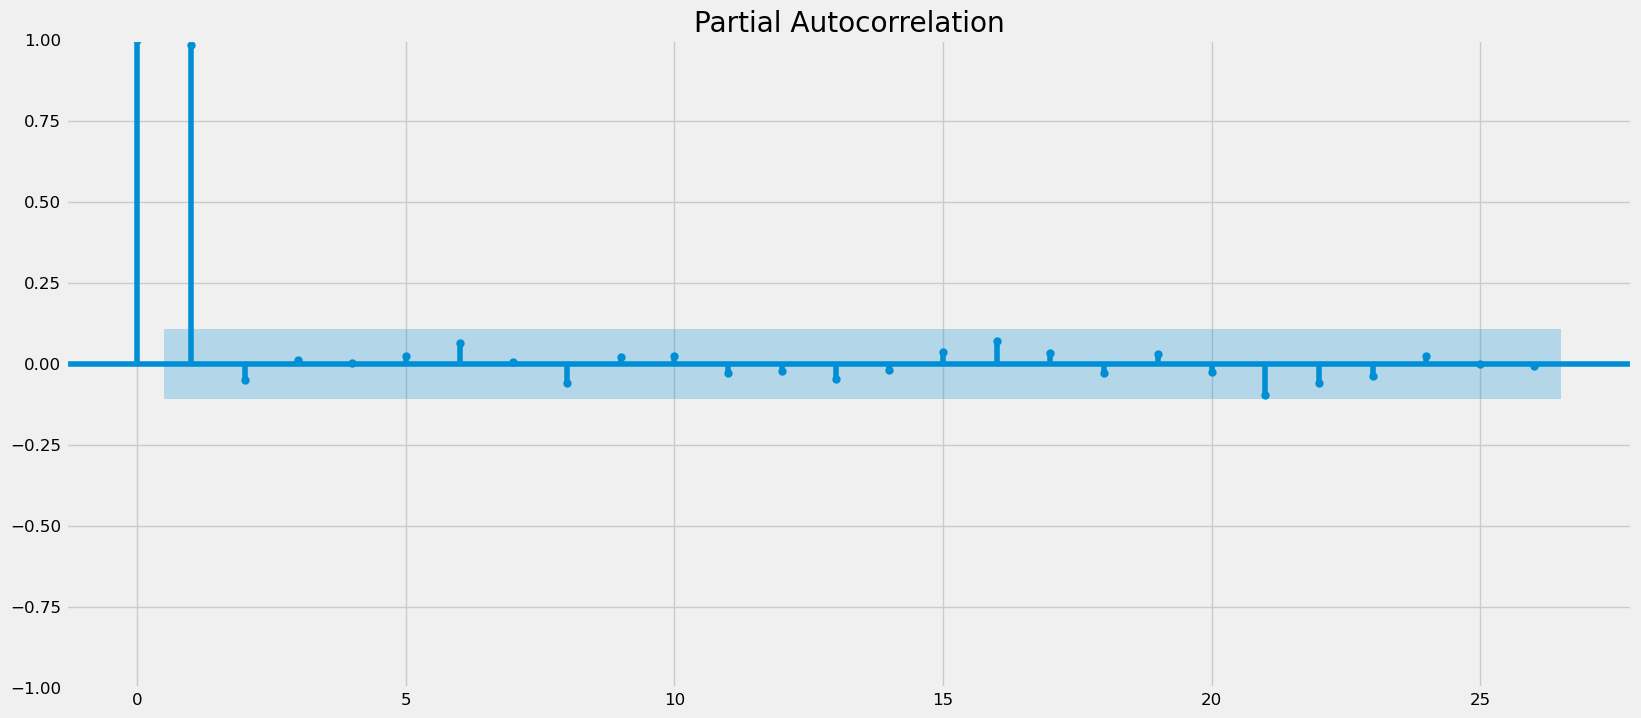

In [27]:
#ACF PACF Plot for echange rate data(non-stationary)
# ACF plot
plot_acf(y)
plt.show()

# PACF plot
plot_pacf(y)
plt.show()

**Interpretation:**

The ACF plot demonstrates exponential decay, indicating a significant autocorrelation at lag 1 and lag 2, followed by a rapid decrease, suggesting an autoregressive (AR) process capturing the data's autocorrelation structure.

Conversely, the PACF plot displays significant spikes at lag 1 and lag 2, indicative of their importance for the autoregressive component of the model.  Therefore, in this scenario, you would typically select p=1 for the AR parameter of the autoregressive integrated moving average (ARIMA) model.No significant spikes are expected beyond the second lag due to the absence of a moving average component (q=1), resembling a sine wave pattern.


In [28]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [29]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           #enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4160.184007252807
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3763.560539685678
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1799.851513176274
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1800.933501915608
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1955.8750259431781
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1956.9702111690397
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1800.6324620170126
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1777.375481029577
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3713.3418267280467
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3315.7670816409563
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1485.3429278529907
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1487.1264727031053
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1625.4412197547058


c:\Users\TEMP.LAPTOP-C50DVQCH.001\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1629.2604782617689
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1487.0723739925224
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1488.739000960253
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1061.2975699495548
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1063.0737469590517
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1236.702481998669
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1057.5302196603386
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1063.0294793282026
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1062.780878058774
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1130.0851951750258
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1059.3209955886464
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1055.9134297704056
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1057.8609382252378
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1235.8603503481513
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1052.6929422326402
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1057.8503825271807
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1057.8278538719442
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1126.817728613

c:\Users\TEMP.LAPTOP-C50DVQCH.001\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1078.0090592131055
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1230.4764444151276
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1062.8997145657122
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1077.8905256023554
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1080.199668366064
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1130.5827688214354
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1064.7996127830456


c:\Users\TEMP.LAPTOP-C50DVQCH.001\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1070.7729200706808


c:\Users\TEMP.LAPTOP-C50DVQCH.001\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1073.0252760101775
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1225.595406916374
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1057.9001184893361
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1072.7101304517132
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1073.8978970308672
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1125.3428255954416
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1059.6606659188835
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1056.939074037185
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1058.9008795516424
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1236.7838564013623
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1053.94916666423
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1058.8930465566848
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1058.956485592805
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1127.6648741368526
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1055.5404444153435
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1053.9635802593466
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1055.6154910774967
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1217.27860096547

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1051.0095209078208 has the lowest AIC value as achieved from the auto arima function

In [30]:
#model Fitting
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      exchange_rate   No. Observations:                  329
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -521.508
Date:                            Fri, 19 Apr 2024   AIC                           1051.017
Time:                                    09:17:26   BIC                           1066.040
Sample:                                01-07-2018   HQIC                          1057.018
                                     - 04-21-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5639      0.202     -2.797      0.005      -0.959      -0.169
ma.L1          0.7173      0.172   

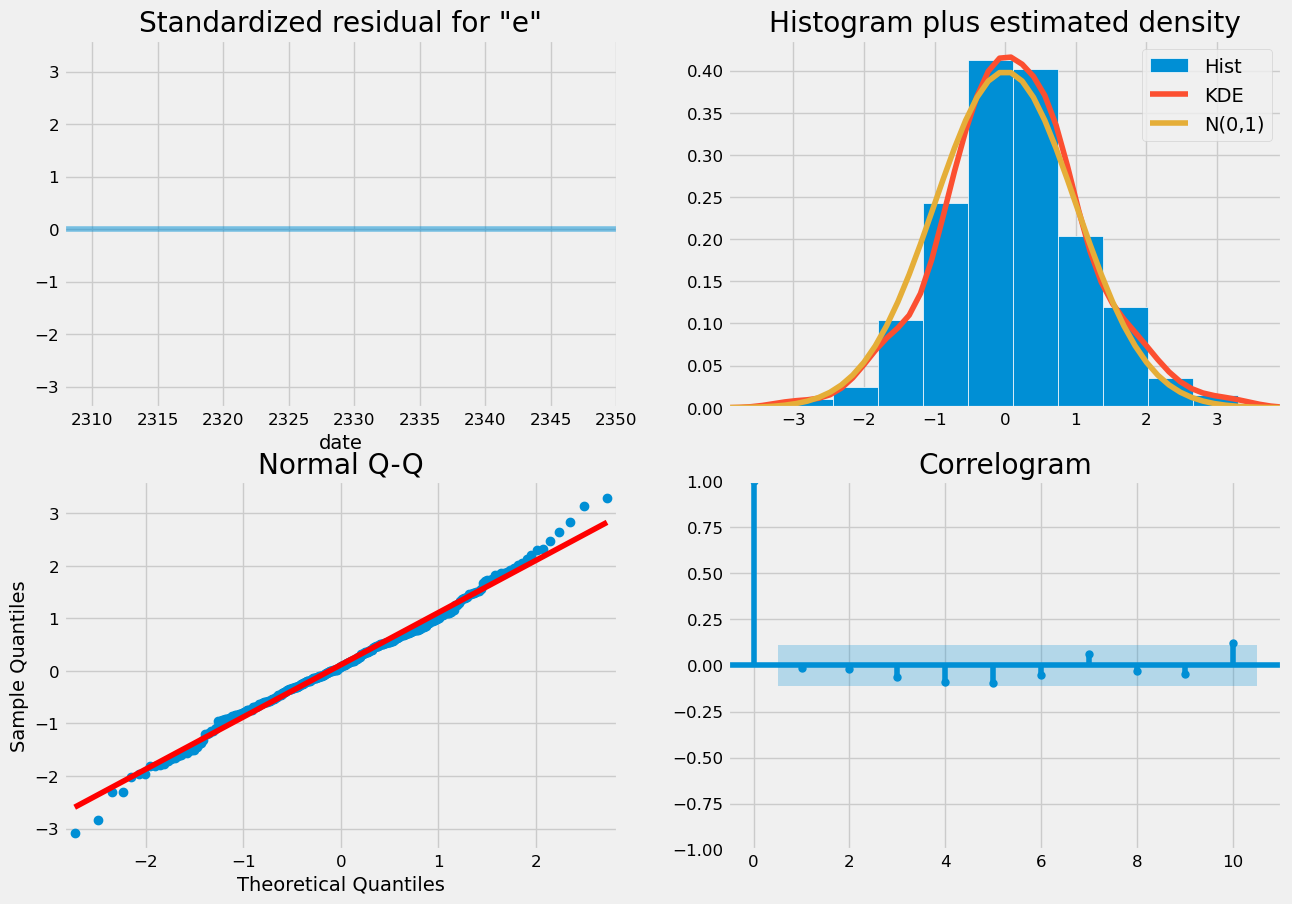

In [31]:
# Model diagnostics
results.plot_diagnostics(figsize=(14,10))
plt.show()

**Interpretation:**
    
Plot 1: Standardized Residual Plot

This plot shows the standardized residuals on the y-axis and date on the x-axis. Standardized residuals are the differences between the actual exchange rates and the values predicted by the model, adjusted to have a standard deviation of 1. 
The horizontal dashed lines at +/- 3 represent the control limits, which are typically used to identify outliers in the data. Points falling outside these limits are considered outliers and may indicate unexpected events that the model didn't account for.
In this specific plot, there appears to be a cluster of residuals around 2020 and 2021 that falls outside the control limits. This suggests potential outliers during that timeframe.

Plot 2: Histogram + Estimated Density

The histogram shows the distribution of the standardized residuals.
By comparing the histogram bars to the density curve, you can see how well the residuals follow a normal distribution.
In this plot, the histogram bars don't perfectly align with the density curve, particularly in the tails. This suggests that the residuals might not be perfectly normally distributed.

Plot 3: Normal Q-Q Plot
This plot compares the quantiles of the standardized residuals against the quantiles of a normal distribution.
In this plot, the points deviate from the straight diagonal line, particularly in the tails. This confirms our observation from the histogram that the residuals likely aren't perfectly normally distributed.

Plot 4: Correlogram

This plot shows the correlation between the standardized residuals at different time lags.
The correlations are represented by bars or lines. Ideally, the correlations should be close to zero at all lags except zero (which will always be 1).
In this plot, it's difficult to discern the correlation values precisely from the image. However, if there are significant spikes at lags greater than zero, it would indicate serial dependence in the residuals.

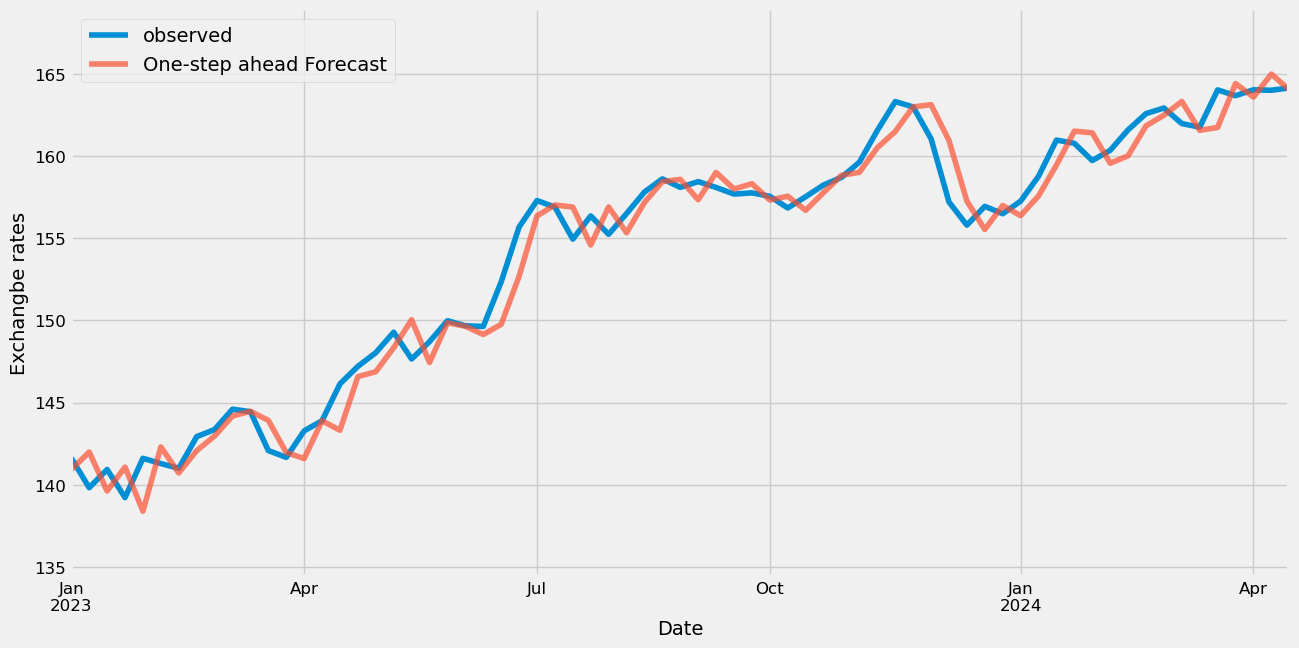

In [32]:
# Fitting the actual values with the forecast value with same index
pred = results.get_prediction(start=pd.to_datetime('2023-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2023':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Exchangbe rates')
plt.legend()
plt.show()

**Interpretation:**
The blue line is the actual exchange rate, while the red line is the forecast exchange rate. The x-axis shows the date, and the y-axis shows the exchange rate.

The forecast shows that the exchange rate is expected to weaken slightly in the next period. However, it is important to note that this is just a forecast, and the actual exchange rate could be higher or lower.

In [33]:
# Check the acccuracy
y_forecasted = pred.predicted_mean
y_truth = y['2024-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1.29
The Root Mean Squared Error of our forecasts is 1.13


In [34]:
# Actual values
y_truth

date
2024-01-07    157.260848
2024-01-14    158.772394
2024-01-21    160.973864
2024-01-28    160.776998
2024-02-04    159.730102
2024-02-11    160.352164
2024-02-18    161.598207
2024-02-25    162.583824
2024-03-03    162.926639
2024-03-10    161.978748
2024-03-17    161.762211
2024-03-24    164.027255
2024-03-31    163.678612
2024-04-07    164.034529
2024-04-14    164.006462
2024-04-21    164.147933
Freq: W-SUN, Name: exchange_rate, dtype: float64

In [35]:
# Forecasted past values
y_forecasted

date
2023-01-01    140.926264
2023-01-08    141.991263
2023-01-15    139.621186
2023-01-22    141.077249
2023-01-29    138.393159
                 ...    
2024-03-24    161.744956
2024-03-31    164.413656
2024-04-07    163.592344
2024-04-14    164.990831
2024-04-21    164.034185
Freq: W-SUN, Name: predicted_mean, Length: 69, dtype: float64

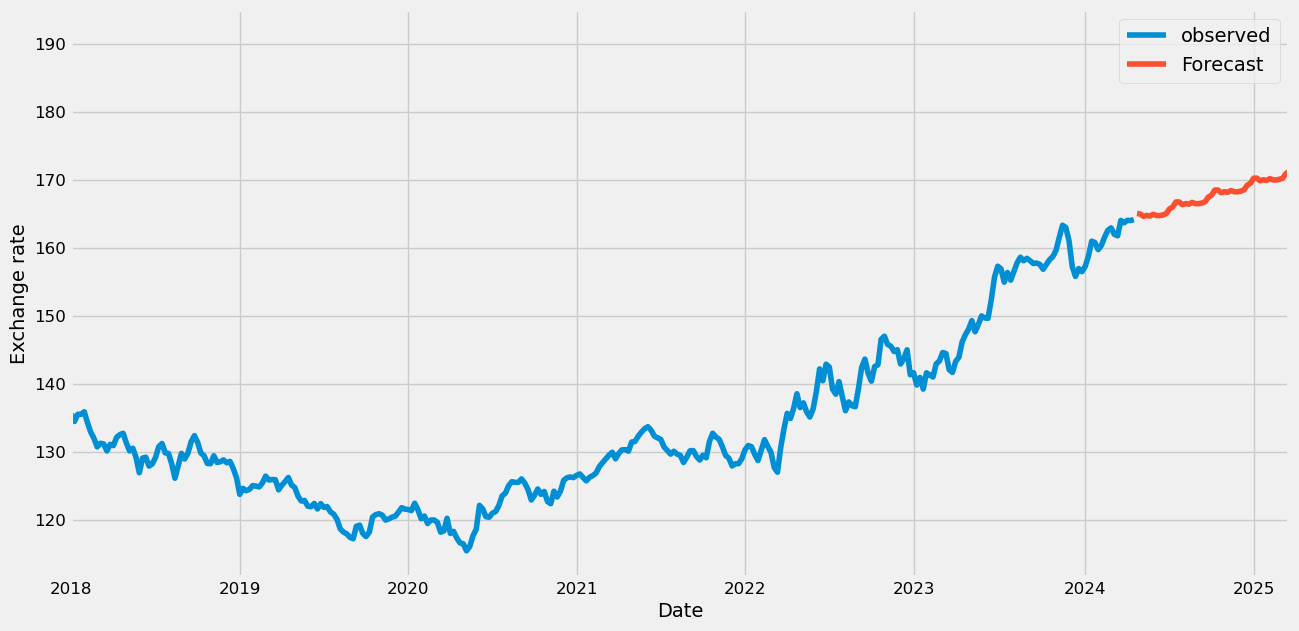

In [36]:
#Forecast plot
pred_uc = results.get_forecast(steps=48)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Exchange rate')
plt.legend()
plt.show()

In [37]:
# Future forecast values
pred_uc = results.get_forecast(steps=48)
forecast_values = pred_uc.predicted_mean

print("Forecast Values of Avg Weekly Exchange rate:")
print(forecast_values)

Forecast Values of Avg Weekly Exchange rate:
2024-04-28    165.054265
2024-05-05    164.968849
2024-05-12    164.620848
2024-05-19    164.756158
2024-05-26    164.672601
2024-06-02    164.926945
2024-06-09    164.748566
2024-06-16    164.738066
2024-06-23    164.833999
2024-06-30    165.018354
2024-07-07    165.707883
2024-07-14    165.995878
2024-07-21    166.743666
2024-07-28    166.747652
2024-08-04    166.349238
2024-08-11    166.512975
2024-08-18    166.413388
2024-08-25    166.676771
2024-09-01    166.493296
2024-09-08    166.485669
2024-09-15    166.579982
2024-09-22    166.765251
2024-09-29    167.454265
2024-10-06    167.742550
2024-10-13    168.490174
2024-10-20    168.494252
2024-10-27    168.095786
2024-11-03    168.259552
2024-11-10    168.159949
2024-11-17    168.423341
2024-11-24    168.239861
2024-12-01    168.232237
2024-12-08    168.326549
2024-12-15    168.511818
2024-12-22    169.200831
2024-12-29    169.489117
2025-01-05    170.236741
2025-01-12    170.240819
2025-

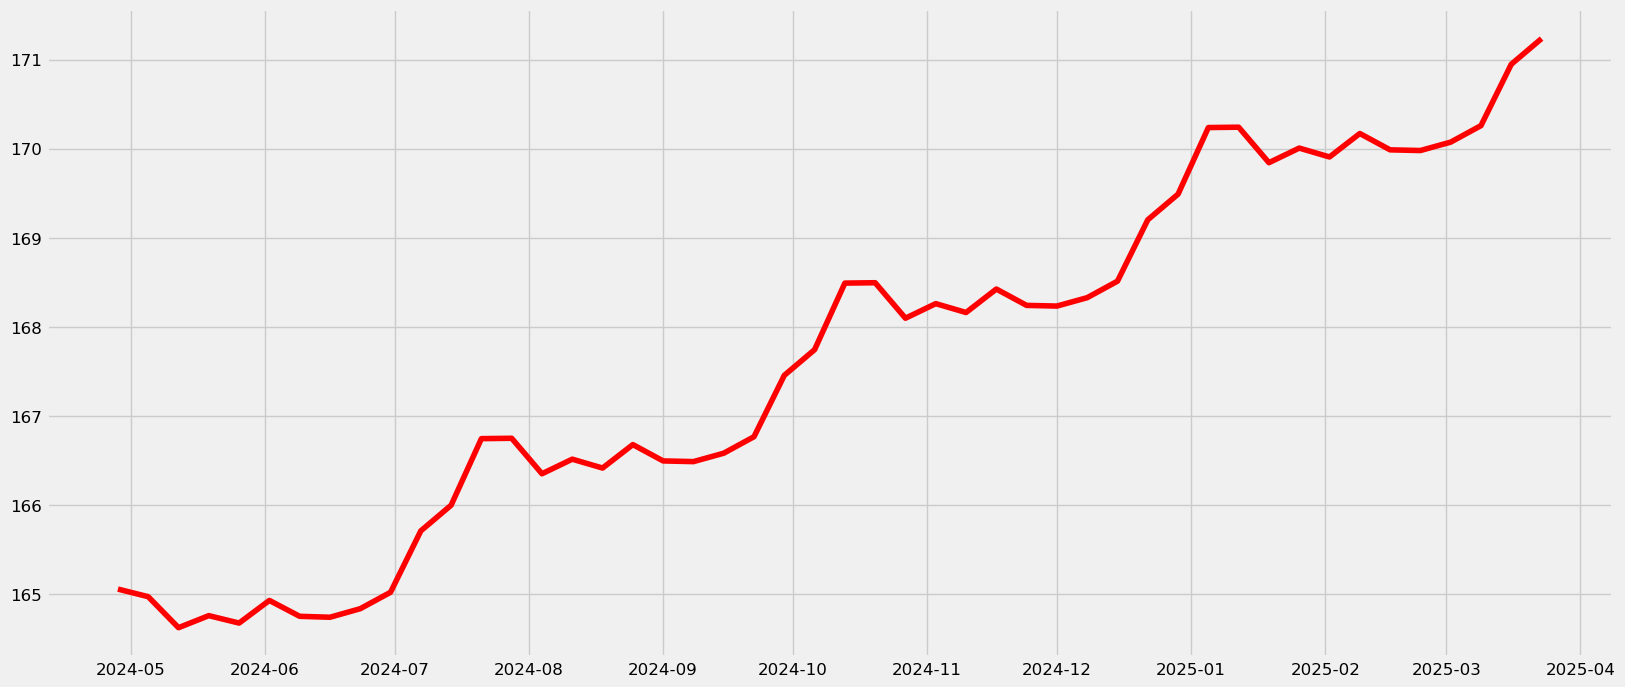

In [38]:
# Forecast plot
plt.plot(forecast_values, color = 'red')

### Exporting data to .csv

In [39]:
# Viewing the current working directory
import os
print(os.getcwd())

c:\Users\TEMP.LAPTOP-C50DVQCH.001\Desktop\Capstone codes


In [40]:
# Forecast values dataframe
df_forecast = pd.DataFrame(forecast_values)

In [41]:
# Original values dataframe
df_original=df_JPY[['exchange_rate']]

In [42]:
# Exporting the data to .csv format
csv_name_1 = 'japan original values.csv'
df_original.to_csv(csv_name_1, index = True)

csv_name_2 = 'japan forecasted values.csv'
df_forecast.to_csv(csv_name_2, index = True)

### FITTING PROPHET MODEL

In [43]:
# Viewing the data
data.head()

,date,exchange_rate
222452,2018-01-01,135.279
222257,2018-01-02,135.323
222116,2018-01-03,135.180
222101,2018-01-04,136.138
221878,2018-01-05,135.970


In [44]:
# Renaming the column
data = data.rename(columns={'date' : 'ds','exchange_rate' : 'y'})

In [45]:
# Number of rows and columns
data.shape

(1690, 2)

In [46]:
# Print the data
data

,ds,y
222452,2018-01-01,135.279000
222257,2018-01-02,135.323000
222116,2018-01-03,135.180000
222101,2018-01-04,136.138000
221878,2018-01-05,135.970000
...,...,...
724,2024-04-12,163.014423
595,2024-04-13,163.554363
378,2024-04-14,163.554332
249,2024-04-15,164.082383


In [47]:
# Fit FB Prophet model and forecast values
m = Prophet()
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

09:17:30 - cmdstanpy - INFO - Chain [1] start processing
09:17:32 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
2050,2025-04-12,183.526369,163.963059,205.102319
2051,2025-04-13,183.741125,163.916946,205.670629
2052,2025-04-14,184.006147,164.177406,205.033400
2053,2025-04-15,184.119986,165.237677,206.107198
2054,2025-04-16,184.253532,164.730968,206.734296


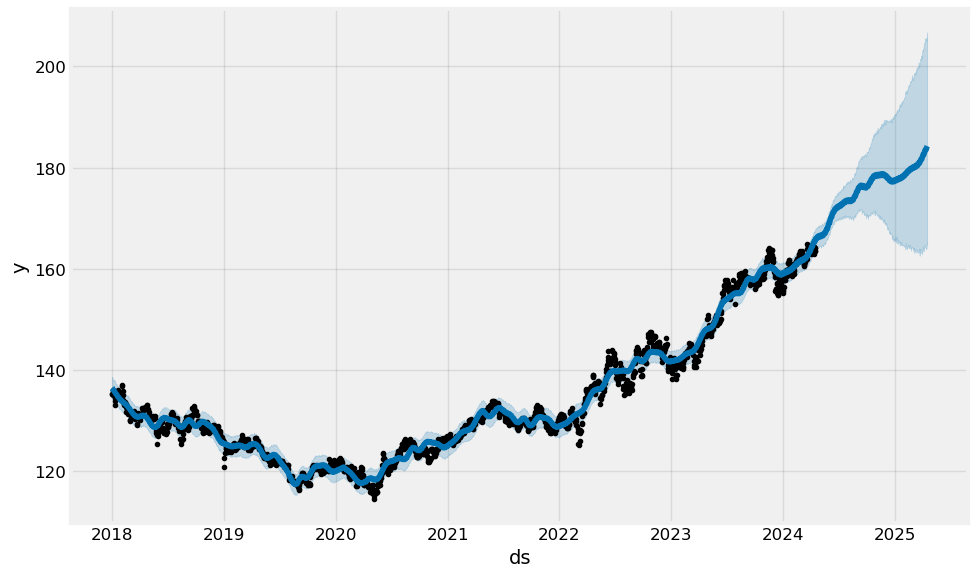

In [48]:
# Forecast plot
fig1 = m.plot(forecast)

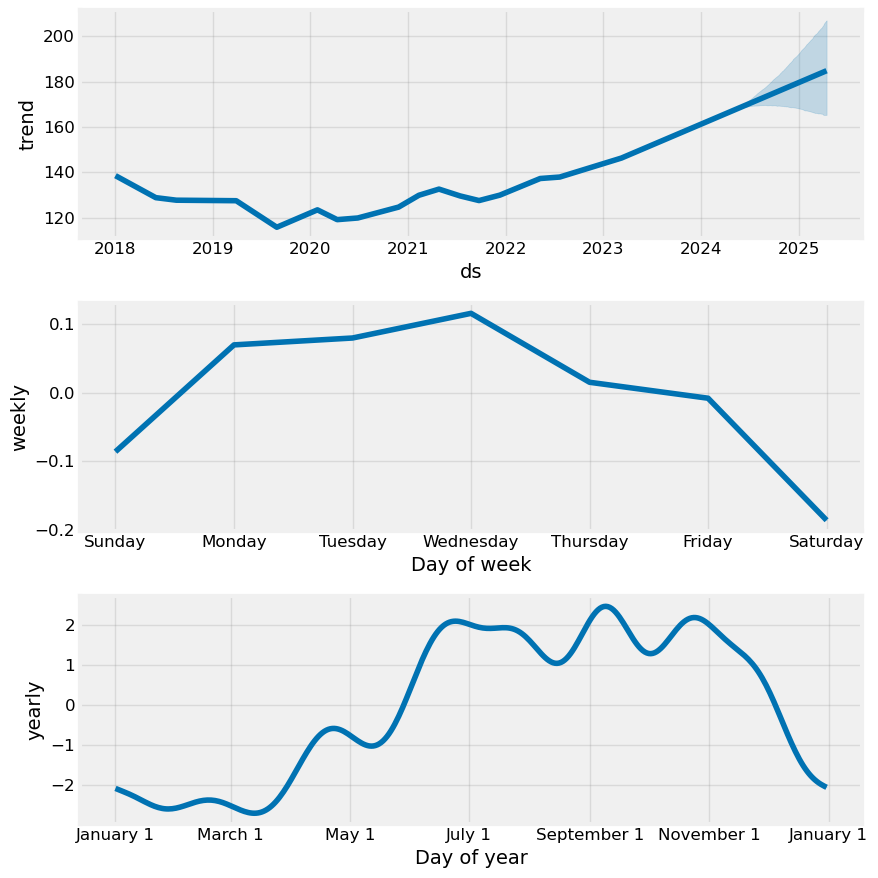

In [49]:
# Model components
fig2 = m.plot_components(forecast)

In [50]:
# Interactive forecast plot
plot_plotly(m, forecast)

In [51]:
# Interactive model complonents plot
plot_components_plotly(m, forecast)

In [54]:
import numpy as np

# Convert lists to numpy arrays or pandas Series
actual_values = np.array(portfolio_values)
predicted_values = np.array([final_portfolio_value] * len(portfolio_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")



MAPE (Mean Absolute Percentage Error): 1.57%


In [73]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Define the initial investment amount
initial_investment = 165  # Euros

# Define the time horizon for the specific week (in weeks)
specific_week = 5  # Change this to the week you want to analyze

# Calculate the weekly returns using the 'predicted_mean' column
weekly_returns = df_forecast['predicted_mean'].pct_change().dropna()

def calculate_volatility(weekly_returns, time_horizon):
    """
    Calculates volatility for a given time horizon.

    Args:
        weekly_returns (pd.Series): A pandas Series of weekly returns.
        time_horizon (float): Time horizon in weeks.
    Returns:
        float: The annualized volatility for the given time horizon.
    """
    annualized_volatility = weekly_returns.std() * np.sqrt(52)  # 52 weeks in a year
    return round(annualized_volatility * np.sqrt(time_horizon / 52), 3)  # Rounded to 3 decimals

def calculate_metrics_for_week(weekly_returns, time_horizon, initial_investment):
    """
    Calculates risk and return metrics for a specific time horizon.

    Args:
        weekly_returns (pd.Series): A pandas Series of weekly returns.
        time_horizon (int): Time horizon in weeks.
        initial_investment (float): Initial investment amount.
    Returns:
        pd.DataFrame: DataFrame containing metrics for the specified time horizon.
    """
    volatility = calculate_volatility(weekly_returns[:time_horizon], time_horizon)
    expected_return = round(weekly_returns[:time_horizon].mean() * 52, 3)  # Annualized and rounded to 3 decimals

    VaR_confidence_level = ES_confidence_level = 0.95

    VaR = round(norm.ppf(1 - VaR_confidence_level) * volatility * np.sqrt(time_horizon / 52), 3)
    ES = round((weekly_returns[:time_horizon][weekly_returns[:time_horizon] <= -VaR].mean() / (1 - ES_confidence_level)) * np.sqrt(time_horizon / 52), 3)

    expected_ROI = round((initial_investment + initial_investment * expected_return) / initial_investment - 1, 3)

    final_portfolio_value = round(initial_investment * (1 + expected_return) ** (time_horizon / 52), 3)

    annualized_growth_rate = round((final_portfolio_value / initial_investment) ** (52 / time_horizon) - 1, 3)

    metrics = {
        'Volatility': volatility,
        'Expected Return': expected_return,
        'VaR (95% Confidence Level)': VaR,
        'ES (95% Confidence Level)': ES,
        'Final Portfolio Value': final_portfolio_value,
        'Annualized Growth Rate': annualized_growth_rate * 100
    }

    return pd.DataFrame([metrics])

# Calculate and display metrics for the specific week
metrics_for_specific_week = calculate_metrics_for_week(weekly_returns, specific_week, initial_investment)

# Print the risk management report line at the top
print(f"Risk Management Report for Week {specific_week}:")
print("----------------------------------------------")

# Print initial investment and time horizon
print(f"Initial Investment: {initial_investment:.3f} Euros")
print(f"Time Horizon (weeks): {specific_week}\n")

# Print the rest of the metrics for the specific week vertically with 3 decimal places
for col, value in metrics_for_specific_week.iteritems():
    print(f"{col}: {value.values[0]:.3f}")


Risk Management Report for Week 5:
----------------------------------------------
Initial Investment: 165.000 Euros
Time Horizon (weeks): 5

Volatility: 0.003
Expected Return: -0.008
VaR (95% Confidence Level): -0.002
ES (95% Confidence Level): -0.001
Final Portfolio Value: 164.873
Annualized Growth Rate: -0.800


In [76]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Define the initial investment amount
initial_investment = 165  # Euros

# Define the time horizon for the specific week (in weeks)
specific_week = 12  # Change this to the week you want to analyze

# Calculate the weekly returns using the 'predicted_mean' column
weekly_returns = df_forecast['predicted_mean'].pct_change().dropna()

def calculate_volatility(weekly_returns, time_horizon):
    """
    Calculates volatility for a given time horizon.

    Args:
        weekly_returns (pd.Series): A pandas Series of weekly returns.
        time_horizon (float): Time horizon in weeks.
    Returns:
        float: The annualized volatility for the given time horizon.
    """
    annualized_volatility = weekly_returns.std() * np.sqrt(52)  # 52 weeks in a year
    return round(annualized_volatility * np.sqrt(time_horizon / 52), 3)  # Rounded to 3 decimals

def calculate_metrics_for_week(weekly_returns, time_horizon, initial_investment):
    """
    Calculates risk and return metrics for a specific time horizon.

    Args:
        weekly_returns (pd.Series): A pandas Series of weekly returns.
        time_horizon (int): Time horizon in weeks.
        initial_investment (float): Initial investment amount.
    Returns:
        pd.DataFrame: DataFrame containing metrics for the specified time horizon.
    """
    volatility = calculate_volatility(weekly_returns[:time_horizon], time_horizon)
    expected_return = round(weekly_returns[:time_horizon].mean() * 52, 3)  # Annualized and rounded to 3 decimals

    VaR_confidence_level = ES_confidence_level = 0.95

    VaR = round(norm.ppf(1 - VaR_confidence_level) * volatility * np.sqrt(time_horizon / 52), 3)
    ES = round((weekly_returns[:time_horizon][weekly_returns[:time_horizon] <= -VaR].mean() / (1 - ES_confidence_level)) * np.sqrt(time_horizon / 52), 3)

    expected_ROI = round((initial_investment + initial_investment * expected_return) / initial_investment - 1, 3)

    final_portfolio_value = round(initial_investment * (1 + expected_return) ** (time_horizon / 52), 3)

    annualized_growth_rate = round((final_portfolio_value / initial_investment) ** (52 / time_horizon) - 1, 3)

    metrics = {
        'Volatility': volatility,
        'Expected Return': expected_return,
        'VaR (95% Confidence Level)': VaR,
        'ES (95% Confidence Level)': ES,
        'Final Portfolio Value': final_portfolio_value,
        'Annualized Growth Rate': annualized_growth_rate * 100
    }

    return pd.DataFrame([metrics])

# Calculate and display metrics for the specific week
metrics_for_specific_week = calculate_metrics_for_week(weekly_returns, specific_week, initial_investment)

# Print the risk management report line at the top
print(f"Risk Management Report for Week {specific_week}:")
print("----------------------------------------------")

# Print initial investment and time horizon
print(f"Initial Investment: {initial_investment:.3f} Euros")
print(f"Time Horizon (weeks): {specific_week}\n")

# Print the rest of the metrics for the specific week vertically with 3 decimal places
for col, value in metrics_for_specific_week.iteritems():
    print(f"{col}: {value.values[0]:.3f}")


Risk Management Report for Week 12:
----------------------------------------------
Initial Investment: 165.000 Euros
Time Horizon (weeks): 12

Volatility: 0.007
Expected Return: 0.044
VaR (95% Confidence Level): -0.006
ES (95% Confidence Level): 0.008
Final Portfolio Value: 166.648
Annualized Growth Rate: 4.400


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the initial investment amount
initial_investment = 165  # Euros

# Define the time horizons (in weeks)
time_horizons = range(1, 53, 1)

# Calculate the weekly returns using the 'predicted_mean' column
weekly_returns = df_forecast['predicted_mean'].pct_change().dropna()

def calculate_volatility(weekly_returns, time_horizon):
    """
    Calculates volatility for a given time horizon.

    Args:
        weekly_returns (pd.Series): A pandas Series of weekly returns.
        time_horizon (float): Time horizon in weeks.
    Returns:
        float: The annualized volatility for the given time horizon.
    """
    annualized_volatility = weekly_returns.std() * np.sqrt(52)  # 52 weeks in a year
    return annualized_volatility * np.sqrt(time_horizon / 52)

def calculate_metrics(weekly_returns, time_horizons, initial_investment):
    """
    Calculates risk and return metrics for multiple time horizons.

    Args:
        weekly_returns (pd.Series): A pandas Series of weekly returns.
        time_horizons (iterable): Iterable containing time horizons in weeks.
        initial_investment (float): Initial investment amount.
    """
    results = []

    for time_horizon in time_horizons:
        volatility = calculate_volatility(weekly_returns[:time_horizon], time_horizon)
        expected_return = weekly_returns[:time_horizon].mean() * 52  # Annualized

        VaR_confidence_level = ES_confidence_level = 0.95

        VaR = norm.ppf(1 - VaR_confidence_level) * volatility * np.sqrt(time_horizon / 52)
        ES = (weekly_returns[:time_horizon][weekly_returns[:time_horizon] <= -VaR].mean() / (1 - ES_confidence_level)) * np.sqrt(time_horizon / 52)

        expected_ROI = (initial_investment + initial_investment * expected_return) / initial_investment - 1

        final_portfolio_value = initial_investment * (1 + expected_return) ** (time_horizon / 52)

        annualized_growth_rate = (final_portfolio_value / initial_investment) ** (52 / time_horizon) - 1

        results.append({
            'Time Horizon (weeks)': time_horizon,
            'Volatility': volatility,
            'Expected Return': expected_return,
            'Expected ROI': expected_ROI * 100,
            'VaR (95% Confidence Level)': VaR,
            'ES (95% Confidence Level)': ES,
            'Final Portfolio Value': final_portfolio_value,
            'Annualized Growth Rate': annualized_growth_rate * 100
        })

    return pd.DataFrame(results)

# Calculate metrics for multiple time horizons
metrics_df = calculate_metrics(weekly_returns, time_horizons, initial_investment)

# Display the results
print("Risk Management Report for Multiple Time Horizons:")
print("----------------------------------------------")
print(metrics_df.to_string(index=False))


Risk Management Report for Multiple Time Horizons:
----------------------------------------------
 Time Horizon (weeks)  Volatility  Expected Return  Expected ROI  VaR (95% Confidence Level)  ES (95% Confidence Level)  Final Portfolio Value  Annualized Growth Rate
                    1         NaN        -0.026910     -2.690992                         NaN                        NaN             164.913466               -2.690992
                    2    0.001592        -0.068302     -6.830195                   -0.000514                  -0.005152             164.551642               -6.830195
                    3    0.002542        -0.031288     -3.128753                   -0.001004                  -0.002890             164.697685               -3.128753
                    4    0.002398        -0.030059     -3.005866                   -0.001094                  -0.003206             164.613089               -3.005866
                    5    0.003146        -0.007984     -0.798368   

In [ ]:
import matplotlib.pyplot as plt

# Extract the predicted values and final portfolio values from the metrics_df DataFrame
predicted_values = df_forecast['predicted_mean'].iloc[:48]
final_portfolio_values = metrics_df['Final Portfolio Value'].iloc[:48].values

# Convert the time horizons to weeks and take the first 48 values
weeks = metrics_df['Time Horizon (weeks)'].iloc[:48].values

# Plot the predicted values and final portfolio values
plt.figure(figsize=(12, 6))
plt.plot(weeks, predicted_values, label='Predicted Values', color='blue')
plt.plot(weeks, final_portfolio_values, label='Final Portfolio Values', color='green')

# Add labels and title
plt.xlabel('Weeks')
plt.ylabel('Value')
plt.title('Predicted Values vs. Final Portfolio Values')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [58]:
df_forecast['predicted_mean']

2024-04-28    165.054265
2024-05-05    164.968849
2024-05-12    164.620848
2024-05-19    164.756158
2024-05-26    164.672601
2024-06-02    164.926945
2024-06-09    164.748566
2024-06-16    164.738066
2024-06-23    164.833999
2024-06-30    165.018354
2024-07-07    165.707883
2024-07-14    165.995878
2024-07-21    166.743666
2024-07-28    166.747652
2024-08-04    166.349238
2024-08-11    166.512975
2024-08-18    166.413388
2024-08-25    166.676771
2024-09-01    166.493296
2024-09-08    166.485669
2024-09-15    166.579982
2024-09-22    166.765251
2024-09-29    167.454265
2024-10-06    167.742550
2024-10-13    168.490174
2024-10-20    168.494252
2024-10-27    168.095786
2024-11-03    168.259552
2024-11-10    168.159949
2024-11-17    168.423341
2024-11-24    168.239861
2024-12-01    168.232237
2024-12-08    168.326549
2024-12-15    168.511818
2024-12-22    169.200831
2024-12-29    169.489117
2025-01-05    170.236741
2025-01-12    170.240819
2025-01-19    169.842353
2025-01-26    170.006119
